## Creating DataSet

In [0]:

import pandas as pd
import random 
import math

from copy import deepcopy
#avoid the modification to original data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

### 1. Drop rows missing target variable

In [0]:
Salaries.dropna(subset=['Q9'],inplace=True) 

In [687]:
Salaries.Q9.unique() 

array(['What is your current yearly compensation (approximate $USD)?',
       '10-20,000', '0-10,000',
       'I do not wish to disclose my approximate yearly compensation',
       '20-30,000', '125-150,000', '30-40,000', '50-60,000',
       '100-125,000', '90-100,000', '70-80,000', '80-90,000', '60-70,000',
       '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

### 2. Remove rows where salary is not disclosed

In [0]:
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"]

### 3. Add Index Column

In [0]:
Salaries.loc[1:,'index'] = Salaries[1:].reset_index().index

### 4. Exported to new file

In [0]:
Salaries.to_csv("Kaggle_Salary_clean.csv")

Data Cleaning Strategy:

1.If a column has less than 1% rows is null, simply drop them.

2.If the question is multi-choice which can be considered as categorical data, assign the mode to them(like python, c++, java or countries)

3.If the size of  null is more than 10% and not belongs to categorical data, mark them as "unknown" or "other"

4.If there is an overwhelming choice in column, fill the missing rows with the term of higher possibility(for between 1% and 10%).

5.If over 50% of data is null, drop column.

In [0]:
class dataCleanNaN(object):
  def __init__(self,salary):
    self.SalaryFrame=salary
  def dropRare(self):
    s=self.SalaryFrame
    all_columns=s.columns
    #print(all_columns)
    for col in all_columns:
      sumNull=s[col].isnull().sum(axis=0)#get specific null sum for a column,axis=0, row side 
      
      if (sumNull<int(s.shape[0]*0.01)) and (sumNull>0):
        print(col)
        s.dropna(subset=[col],inplace=True) 

        print (s.shape)
    return s
  def fillMode(self,salary):
    all_columns=salary.columns
    for col in all_columns:
      sumNull=salary[col].isnull().sum(axis=0)#get specific null sum for a column
      
      if (sumNull>int(salary.shape[0]*0.01)) and (sumNull<int(salary.shape[0]*0.1)):
        print(col)
        salary[col].fillna(salary[col].mode()[0],inplace=True)
    return salary
  def unknownReplace(self,salary):
    all_columns=salary.columns
    for col in all_columns:
      sumNull=salary[col].isnull().sum(axis=0)#get specific null sum for a column
      
      if (sumNull>int(salary.shape[0]*0.1)) and (sumNull<int(salary.shape[0]*0.5)):
        
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):#avoid taking the multi choice questions
          print(col)
          salary.loc[salary[col].isnull(),col] = 'Unknown'
    return salary

In [692]:
cleanProcess=dataCleanNaN(Salaries)
droppedSalary=cleanProcess.dropRare()

Q5
(15295, 396)
Q8
(15220, 396)
index
(15219, 396)


In [693]:
modeSalary=cleanProcess.fillMode(droppedSalary)

Q10


In [694]:
unknowSalary=cleanProcess.unknownReplace(modeSalary)

Q12_MULTIPLE_CHOICE
Q17
Q18
Q20
Q22
Q23
Q24
Q25
Q26
Q32
Q39_Part_1
Q39_Part_2
Q40
Q43
Q46
Q48


To handle categorical data, we can either assign dummy values or give the mode values to missed spaces or values like'unknown' or 'other'

In [0]:
class dataCleanGeneral(object):
  def __init__(self,salary):
    self.SalaryFrame=salary
    self.ALLCOL=salary.columns.tolist()
  def categorical(self,columns,salary):
    #dealing with catagorical data without numerical values, assign dummy values
    for col in columns:
      print(col)
      salary = pd.get_dummies(data=salary, columns=[col])

    return salary
  def featureMinimize(self,columns,salary):
    #for columns that has too many different values, minimize it to an acceptable range
    for col in columns:
      valueCount=salary[col].value_counts()#count all unique values,Return a Series containing counts of unique values.
      value_mask = salary[col].isin(valueCount.index[valueCount < 100])#find all indexes that has a number of less than 100
      salary.loc[value_mask,col] = "Other"#mark indexes less than 100 as others
      salary = pd.get_dummies(data=salary, columns=[col])
    return salary
  def select_col(self,condition):
    allcol=self.ALLCOL
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected 

In [696]:
DummyCols = ['Q1','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE','Q17','Q18','Q20','Q23','Q26','Q32','Q39_Part_1', 'Q39_Part_2','Q40','Q48']
minimizeCols=['Q3','Q22']
generalModel=dataCleanGeneral(unknowSalary)
catgorySalary=generalModel.categorical(DummyCols,unknowSalary)
#catgorySalary.head(3)
miniSalary=generalModel.featureMinimize(minimizeCols,catgorySalary)
miniSalary.head(3)
#catgorySalary.head(3)

Q1
Q4
Q5
Q6
Q7
Q10
Q12_MULTIPLE_CHOICE
Q17
Q18
Q20
Q23
Q26
Q32
Q39_Part_1
Q39_Part_2
Q40
Q48


,Time from Start to Finish (seconds),Q1_OTHER_TEXT,Q2,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Q8,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,...,"Q48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs",Q48_Unknown,"Q48_Yes, most ML models are ""black boxes""",Q3_Australia,Q3_Brazil,Q3_Canada,Q3_China,Q3_Colombia,Q3_France,Q3_Germany,Q3_I do not wish to disclose my location,Q3_India,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Poland,Q3_Portugal,Q3_Russia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q22_D3,Q22_Matplotlib,Q22_Other,Q22_Plotly,Q22_Seaborn,Q22_Shiny,Q22_Unknown,Q22_ggplot2
2,434,-1,30-34,0,-1,5-10,"10-20,000",NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,-1,1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,718,-1,30-34,-1,-1,0-1,"0-10,000",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
5,731,-1,22-24,-1,-1,0-1,"0-10,000",NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,-1,1,-1,-1,-1,-1,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,Azure Notebook,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


For data that contains numerical values, we replace their original data with mean or other reasonable values. In the mean time, handle special data cases and replace them.

In [0]:
class dataCleanSpecialCases(object):
  def __init__(self,salary):
    self.SalaryFrame=salary
  def Range_Normalize(self,value):
    #questions like q2 and q8 has numerical values, thus need extract value from answer string
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        if '+' in value:
            a = value.split('+')
            return float(a[0])
        else:
            return value
    else:
        return value
  def Q24Range_Normalize(self,value):
    #print(value)
    mapdict = {'Unknown':0,'I have never written code and I do not want to learn':-1,'I have never written code but I want to learn':0,'< 1 year':0.5,'1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,'20-30 years':25,'30-40 years':35,'40+ years':40}
    return mapdict[value]
  def Q25Range_Normalize(self,value):
    mapdict = {'Unknown':0,'I have never studied machine learning and I do not plan to':-1,'I have never studied machine learning but plan to learn in the future':0,'< 1 year':0.5,'1-2 years':1.5,'2-3 years':2.5,'3-4 years':3.5,'4-5 years':4.5,'5-10 years':7.5,'10-15 years':12.5,'20+ years':20}
    return mapdict[value]
  def Q41Range_Normalize(self,value):
    mapdict = {'Unknown':0,'Very important':10,'Slightly important':5,'No opinion; I do not know':2,'Unknown':0,'Not at all important':-10}
    return mapdict[value]
  def Q43Range_Normalize(self,value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        elif value == "0":
            return 0
        else:
            return float("nan")
    else:
        return value

In [698]:
specialModel=dataCleanSpecialCases(miniSalary)
miniSalary['Q2_NORMAL'] = miniSalary['Q2'].apply(specialModel.Range_Normalize)
miniSalary.drop(['Q2'],axis=1,inplace=True)
miniSalary['Q8_NORMAL'] = miniSalary['Q8'].apply(specialModel.Range_Normalize)
miniSalary.drop(['Q8'],axis=1,inplace=True)
miniSalary.head(3)

,Time from Start to Finish (seconds),Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,...,"Q48_Yes, most ML models are ""black boxes""",Q3_Australia,Q3_Brazil,Q3_Canada,Q3_China,Q3_Colombia,Q3_France,Q3_Germany,Q3_I do not wish to disclose my location,Q3_India,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Poland,Q3_Portugal,Q3_Russia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q22_D3,Q22_Matplotlib,Q22_Other,Q22_Plotly,Q22_Seaborn,Q22_Shiny,Q22_Unknown,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL
2,434,-1,0,-1,"10-20,000",NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,-1,1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,32.0,7.5
3,718,-1,-1,-1,"0-10,000",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,32.0,0.5
5,731,-1,-1,-1,"0-10,000",NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,-1,1,-1,-1,-1,-1,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,Azure Notebook,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,23.0,0.5


In [0]:
miniSalary['Q24_NORMAL'] = miniSalary['Q24'].apply(specialModel.Q24Range_Normalize)
miniSalary.drop(['Q24'],axis=1,inplace=True)

In [0]:
miniSalary['Q25_NORMAL'] = miniSalary['Q25'].apply(specialModel.Q25Range_Normalize)
miniSalary.drop(['Q25'],axis=1,inplace=True)

In [0]:
miniSalary.loc[miniSalary['Q41_Part_1'].isnull(),'Q41_Part_1'] = 'Unknown'
miniSalary.loc[miniSalary['Q41_Part_2'].isnull(),'Q41_Part_2'] = 'Unknown'
miniSalary.loc[miniSalary['Q41_Part_3'].isnull(),'Q41_Part_3'] = 'Unknown'

miniSalary['Q41_Part_1_NORMAL'] = miniSalary['Q41_Part_1'].apply(specialModel.Q41Range_Normalize)
miniSalary.drop(['Q41_Part_1'],axis=1,inplace=True)
miniSalary['Q41_Part_2_NORMAL'] = miniSalary['Q41_Part_2'].apply(specialModel.Q41Range_Normalize)
miniSalary.drop(['Q41_Part_2'],axis=1,inplace=True)
miniSalary['Q41_Part_3_NORMAL'] = miniSalary['Q41_Part_3'].apply(specialModel.Q41Range_Normalize)
miniSalary.drop(['Q41_Part_3'],axis=1,inplace=True)

In [0]:
miniSalary['Q43_NORMAL'] = miniSalary['Q43'].apply(specialModel.Q43Range_Normalize)
miniSalary.drop(['Q43'],axis=1,inplace=True)
miniSalary['Q43_NORMAL'].fillna(miniSalary['Q43_NORMAL'].mode()[0],inplace=True)

In [703]:
miniSalary['Q46_NORMAL'] = miniSalary['Q46'].apply(specialModel.Q43Range_Normalize)
miniSalary.drop(['Q46'],axis=1,inplace=True)
miniSalary['Q46_NORMAL'].fillna(miniSalary['Q46_NORMAL'].mode()[0],inplace=True)
miniSalary.head(3)

,Time from Start to Finish (seconds),Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,...,Q3_Germany,Q3_I do not wish to disclose my location,Q3_India,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Poland,Q3_Portugal,Q3_Russia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q22_D3,Q22_Matplotlib,Q22_Other,Q22_Plotly,Q22_Seaborn,Q22_Shiny,Q22_Unknown,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL,Q24_NORMAL,Q25_NORMAL,Q41_Part_1_NORMAL,Q41_Part_2_NORMAL,Q41_Part_3_NORMAL,Q43_NORMAL,Q46_NORMAL
2,434,-1,0,-1,"10-20,000",NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,-1,1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,32.0,7.5,0.0,0.0,0,0,0,0.0,15.0
3,718,-1,-1,-1,"0-10,000",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,32.0,0.5,7.5,0.5,10,10,10,5.0,15.0
5,731,-1,-1,-1,"0-10,000",NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,-1,1,-1,-1,-1,-1,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,Azure Notebook,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,23.0,0.5,7.5,2.5,-10,5,10,25.0,25.0


In [0]:
def Binarize(value):
    if isinstance(value,str):
      #mark cell as 1 as long as the cell is filled
        return 1
    else:
        if value == 0 or math.isnan(value):
            return 0
        else:
            return 1
def binarize_col(columns, data):
    for col in columns:
        data[col] = data[col].apply(Binarize)
NormalCols = generalModel.select_col('Q11_Part') + generalModel.select_col('Q13_Part') + \
generalModel.select_col('Q14_Part') + generalModel.select_col('Q15_Part') + generalModel.select_col('Q16_Part')\
+ generalModel.select_col('Q19_Part') + generalModel.select_col('Q21_Part') + generalModel.select_col('Q27_Part')\
+ generalModel.select_col('Q28_Part') + generalModel.select_col('Q29_Part') + generalModel.select_col('Q30_Part') +\
generalModel.select_col('Q31_Part') + generalModel.select_col('Q33_Part') + generalModel.select_col('Q34_Part') +\
generalModel.select_col('Q36_Part') + generalModel.select_col('Q38_Part') + generalModel.select_col('Q42_Part') + \
generalModel.select_col('Q44_Part') + generalModel.select_col('Q45_Part') + generalModel.select_col('Q47_Part') + \
generalModel.select_col('Q49_Part') + generalModel.select_col('Q50_Part')

binarize_col(NormalCols,miniSalary)

For these question, we simply mark cell as 1 as long as the cell is filled

In [705]:
miniSalary.head(3)

,Time from Start to Finish (seconds),Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,...,Q3_Germany,Q3_I do not wish to disclose my location,Q3_India,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Poland,Q3_Portugal,Q3_Russia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q22_D3,Q22_Matplotlib,Q22_Other,Q22_Plotly,Q22_Seaborn,Q22_Shiny,Q22_Unknown,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL,Q24_NORMAL,Q25_NORMAL,Q41_Part_1_NORMAL,Q41_Part_2_NORMAL,Q41_Part_3_NORMAL,Q43_NORMAL,Q46_NORMAL
2,434,-1,0,-1,"10-20,000",0,0,0,0,0,1,0,-1,1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,32.0,7.5,0.0,0.0,0,0,0,0.0,15.0
3,718,-1,-1,-1,"0-10,000",1,0,0,0,0,0,0,-1,-1,-1,-1,0,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,32.0,0.5,7.5,0.5,10,10,10,5.0,15.0
5,731,-1,-1,-1,"0-10,000",0,0,0,0,0,0,1,-1,-1,1,-1,-1,-1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,23.0,0.5,7.5,2.5,-10,5,10,25.0,25.0


In [0]:
def TBinarize(value):
    if isinstance(value,str):
      #as long as there is a value, return its float type, otherwise return -1
        return float(value)
    else:
        if math.isnan(value):
            return -1
        else:
            return value
def Tbinarize_col(columns, data):
    for col in columns:
        data[col] = data[col].apply(TBinarize)

Tbinarize_col(generalModel.select_col('Q34_Part'),miniSalary)
Tbinarize_col(generalModel.select_col('Q35_Part'),miniSalary)

In [707]:
miniSalary['Q9'].unique()

array(['10-20,000', '0-10,000', '20-30,000', '125-150,000', '30-40,000',
       '50-60,000', '100-125,000', '90-100,000', '70-80,000', '80-90,000',
       '60-70,000', '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

In [0]:
miniSalary.drop(['Q37'], axis=1,inplace=True)

Q37 dropped for containing too many nans

In [0]:
k=miniSalary.isnull().sum(axis=0)
for items in k.iteritems():
  if items[1]!=0:
    print(items)

Iterate through the cleaned dataset to see if any term still has null

In [710]:
print (type(miniSalary['Q9']))
for col in miniSalary.columns:
  for items in miniSalary[col].iteritems():
    if items[1]=="Unknown":
      print (col)
      break

<class 'pandas.core.series.Series'>


In [711]:
def Q9Process(value):

    #questions like q2 and q8 has numerical values, thus need extract value from answer string
  if isinstance(value, str):
      if '-' in value:
          temp = value.split('-')
          upper=temp[1].split(',')
          resultValue=float(upper[0])*1000
          return (float(temp[0])*1000+resultValue)/2
      if '+' in value:
          a = value.split('+')
          up=a[0].split(',')
          upValue=float(up[0])*1000
          return upValue
      else:
          return value
  else:
      return value

miniSalary.rename(columns={"Q9": "Yearly_Income"},inplace=True)
miniSalary["Yearly_Income"]=miniSalary["Yearly_Income"].apply(Q9Process)
for col in miniSalary.columns:
  #print(type(miniSalary.loc[1,col]),miniSalary.loc[1,col])
  if isinstance(miniSalary.loc[2,col],str):
    #print(type(miniSalary.loc[1,col]),miniSalary.loc[1,col])
    miniSalary[col] = miniSalary[col].apply(lambda x:float(x))

miniSalary.rename(columns={"Time from Start to Finish (seconds)": "TimeUse"},inplace=True)
miniSalary.drop(miniSalary[miniSalary.TimeUse < 180].index,inplace=True)#need to convert all data from str to float
miniSalary.head(3)
#print(type(miniSalary.TimeUse.at[2]))
#miniSalary.loc[2,'TimeUse']

,TimeUse,Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Yearly_Income,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,...,Q3_Germany,Q3_I do not wish to disclose my location,Q3_India,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Poland,Q3_Portugal,Q3_Russia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q22_D3,Q22_Matplotlib,Q22_Other,Q22_Plotly,Q22_Seaborn,Q22_Shiny,Q22_Unknown,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL,Q24_NORMAL,Q25_NORMAL,Q41_Part_1_NORMAL,Q41_Part_2_NORMAL,Q41_Part_3_NORMAL,Q43_NORMAL,Q46_NORMAL
2,434.0,-1.0,0.0,-1.0,15000.0,0,0,0,0,0,1,0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,32.0,7.5,0.0,0.0,0,0,0,0.0,15.0
3,718.0,-1.0,-1.0,-1.0,5000.0,1,0,0,0,0,0,0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,32.0,0.5,7.5,0.5,10,10,10,5.0,15.0
5,731.0,-1.0,-1.0,-1.0,5000.0,0,0,0,0,0,0,1,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,23.0,0.5,7.5,2.5,-10,5,10,25.0,25.0


In [712]:
miniSalary.shape

(14523, 592)

Possible reasons for  missing values:some question type are not suppoesed to be fully filled like multi-choice questions. In addition, some question are considered private by the respondant like yearly income or ages.

Impact on analysis:To deal with missing values, I basically used three methods, drop the missing spaces, replace them with a dummy value or assign them with the mode values. In the beginning if we drop too much data and our training dataset may not have enough data and it may lead to an overfitting to our model. But dropping missing values is acceptable as long as we have sufficient training data and it may also helps to eliminate the noise in the dataset. Assigning mode values to the missing values will likely to make our model more "extreme" because the missed parts are all filled with the high ranked values. As for dummy value assignment, the missed parts are filled with 0 or 1(depands on the data) which is helpful for vectorize and machine learning trainning steps.

# Q2 Exploratory Data Analysis a

In [713]:
visual_Salary=pd.read_csv("Kaggle_Salary_clean.csv", encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,9,11,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We want to create three graphs, each one of them represents the distribution of yearly income, the relation between the undergraduate major and salary, the relation between highest degree and salary.

In [714]:
#handle categorical data
#visualModel=dataCleanGeneral(visual_Salary)
#for salary distribution we use directly from previous question
miniSalary["Yearly_Income"].unique()

array([ 15000.,   5000.,  25000., 137500.,  35000.,  55000., 112500.,
        95000.,  75000.,  85000.,  65000., 450000.,  45000., 175000.,
       500000., 350000., 225000., 275000.])

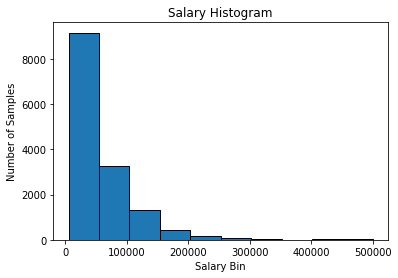

In [715]:
%matplotlib inline
plt.hist(miniSalary['Yearly_Income'], bins=10, edgecolor='black')
plt.title("Salary Histogram")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

In [0]:
visual_Salary.loc[0]['Q4']
visual_Salary=visual_Salary.drop([0])#remove the row that has all questions

In [717]:
print(visual_Salary['Q5'].unique())
visual_Salary.loc[visual_Salary['Q5'].isnull(),'Q5']="Unknown"
visual_Salary["Q9"]=visual_Salary["Q9"].apply(Q9Process)
Q9=visual_Salary

['Engineering (non-computer focused)'
 'Computer science (software engineering, etc.)'
 'Mathematics or statistics'
 'Information technology, networking, or system administration'
 'A business discipline (accounting, economics, finance, etc.)'
 'Environmental science or geology'
 'Medical or life sciences (biology, chemistry, medicine, etc.)'
 'I never declared a major' 'Other' 'Physics or astronomy'
 'Social sciences (anthropology, psychology, sociology, etc.)'
 'Humanities (history, literature, philosophy, etc.)' nan
 'Fine arts or performing arts']


<bound method DataFrame.mean of                                                              mean
Q5                                                               
A business discipline (accounting, economics, f...   60488.372093
Computer science (software engineering, etc.)        41112.093650
Engineering (non-computer focused)                   53107.533414
Environmental science or geology                     54971.428571
Fine arts or performing arts                        101737.288136
Humanities (history, literature, philosophy, etc.)   77523.809524
I never declared a major                             60183.823529
Information technology, networking, or system a...   36440.809969
Mathematics or statistics                            55665.380906
Medical or life sciences (biology, chemistry, m...   57308.943089
Other                                                51432.865731
Physics or astronomy                                 66622.182681
Social sciences (anthropology, psychology, s

Text(0, 0.5, 'Salary Mean Values')

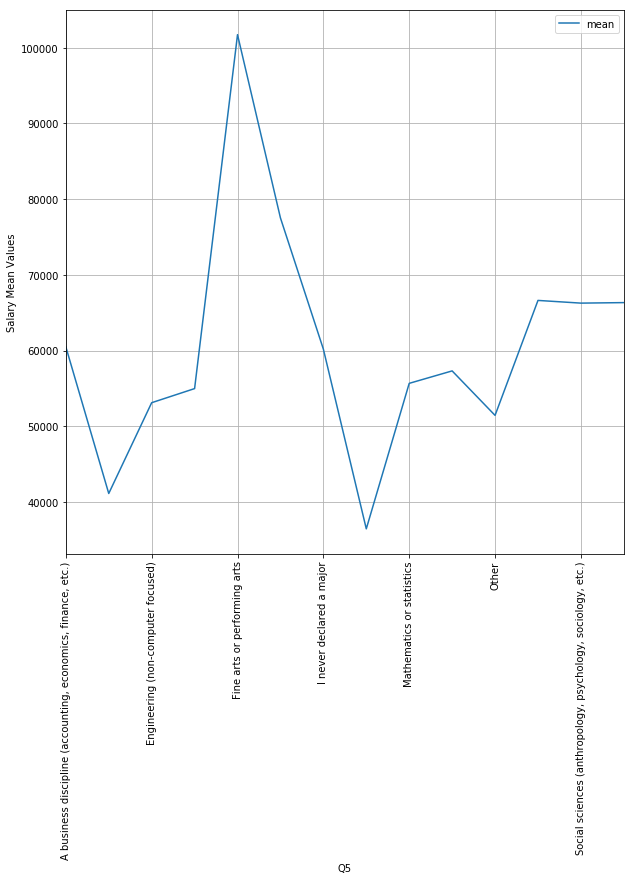

In [718]:
meanDegreeSalary=visual_Salary.groupby(['Q5']).Q9.agg(['mean'])
print(meanDegreeSalary.mean)
meanDegreeSalary.plot(y='mean',figsize=(10,10), grid=True)
plt.xticks( rotation=90)
plt.ylabel("Salary Mean Values")

In [719]:


valueCount=Q9["Q3"].value_counts()#count all unique values,Return a Series containing counts of unique values.
value_mask = Q9["Q3"].isin(valueCount.index[valueCount < 200])#find all indexes that has a number of less than 100
Q9.loc[value_mask,"Q3"] = "Other"
Q9.loc[Q9['Q3'].isnull(),'Q3']="Unkown"
Q9['Q9'].unique()

array([ 15000.,   5000.,  25000., 137500.,  35000.,  55000., 112500.,
        95000.,  75000.,  85000.,  65000., 450000.,  45000., 175000.,
       500000., 350000., 225000., 275000.])

<bound method Series.mean of Q3
Australia                                               85993.589744
Brazil                                                  26876.122083
Canada                                                  68798.185941
China                                                   23824.712644
France                                                  50390.070922
Germany                                                 57702.569170
India                                                   22471.982759
Italy                                                   37028.688525
Japan                                                   56207.524272
Other                                                   36747.428571
Poland                                                  29205.607477
Russia                                                  23868.330465
Spain                                                   38255.494505
United Kingdom of Great Britain and Northern Ireland    64858.585859
Un

Text(0, 0.5, 'Salary Mean Values')

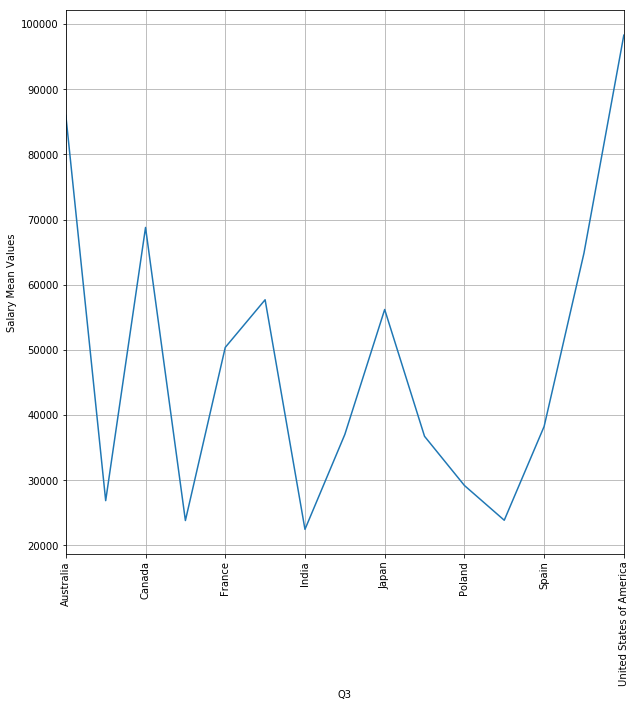

In [720]:
meanCountrySalary=Q9.groupby(['Q3']).Q9.mean()
print(meanCountrySalary.mean)
meanCountrySalary.plot(y='mean',figsize=(10,10), grid=True)
plt.xticks( rotation=90)
plt.ylabel("Salary Mean Values")

Trends in the Data:

1.From the first graph, we can see the distribution of salary among different value groups. The majority of income is below 100,000 dollars and the number decreases as the income increases.

2.The second graph tells us the relation between the undergraduate major and yearly income, from which we can see that surprisingly the fine art graduates earn the most among other majors.

3.The last graph shows the relation between data scientist's residence country and their wage, as we know the economic level differs a lot from country to country thus this feature can tells us which countries are likely to provide higher salary for data scientists.

# Q3 Fearture Selection &Exploratory data analysis b

> Indented block



In [0]:

def RfeSelection(train_Data_X,train_label_Y):
  #model_lr = LogisticRegression(solver='lbfgs',max_iter=4000)
  model_lr=LinearRegression()
  rfe = RFE(model_lr)
  fit = rfe.fit(train_Data_X, train_label_Y)
  return sorted(list(zip(fit.ranking_,train_Data_X.columns)))


In [722]:
salary_Train_label_Y=miniSalary.loc[:,'Yearly_Income']
salary_Train_Data_X=miniSalary.drop('Yearly_Income',axis=1)
print(salary_Train_label_Y.shape,salary_Train_Data_X.shape,salary_Train_label_Y.unique())

(14523,) (14523, 591) [ 15000.   5000.  25000. 137500.  35000.  55000. 112500.  95000.  75000.
  85000.  65000. 450000.  45000. 175000. 500000. 350000. 225000. 275000.]


In [723]:
y_list=(salary_Train_label_Y.unique()).tolist()

y_list.sort()
print(y_list)

[5000.0, 15000.0, 25000.0, 35000.0, 45000.0, 55000.0, 65000.0, 75000.0, 85000.0, 95000.0, 112500.0, 137500.0, 175000.0, 225000.0, 275000.0, 350000.0, 450000.0, 500000.0]


In [0]:
feature_Rank=RfeSelection(salary_Train_Data_X[0:6000],salary_Train_label_Y[0:6000])

In [725]:
feature_Rank[:10]
print(len(feature_Rank))
feature_backup=feature_Rank

591


In [726]:
salary_Train_Data_X.shape

(14523, 591)

In [727]:
extractedFeatures=[]
for item in feature_backup:
  if item[0]==1:
    
    extractedFeatures.append(item[1])
print(len(feature_backup))
print(len(extractedFeatures),extractedFeatures[0:10])

591
295 ['Q10_I do not know', 'Q10_No (we do not use ML methods)', 'Q10_We are exploring ML methods (and may one day put a model into production)', 'Q10_We have well established ML methods (i.e., models in production for more than 2 years)', 'Q10_We recently started using ML methods (i.e., models in production for less than 2 years)', 'Q10_We use ML methods for generating insights (but do not put working models into production)', 'Q11_Part_4', 'Q11_Part_7', 'Q12_MULTIPLE_CHOICE_Advanced statistical software (SPSS, SAS, etc.)', 'Q12_MULTIPLE_CHOICE_Basic statistical software (Microsoft Excel, Google Sheets, etc.)']


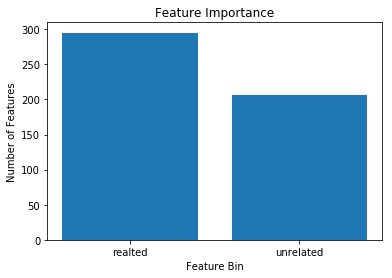

In [728]:
featureNames=['realted','unrelated']
featureNumber=[295,206]

plt.bar(featureNames,featureNumber)
plt.title("Feature Importance")
plt.xlabel("Feature Bin")
plt.ylabel("Number of Features")
plt.show()

Feature Importance Visualize:To rank the features by their importance, we use the rfe algorithm to rank the features by running a linear regression algorithm on the raw dataset, the reason why we choose linear regression is because it is more simple than logistic regression and easier to converge. After that, we extract the outcomes and seperate the results into related and unrelated according to their rank(all features ranked 1 are considered as related, while the rest are all unrelated). Finally, we plot the above graph to visualize the importance and we can see that there are around 300 features considered realted while around 250 features are not.

In [729]:
featuredSalary=salary_Train_Data_X[extractedFeatures]
pca = PCA(n_components=250)
pca.fit(featuredSalary)
featuredSalary = pca.transform(featuredSalary)

featuredSalary = pd.DataFrame(featuredSalary)
featuredSalary.head(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,13.275016,-7.446401,4.142108,33.448202,-9.976300,-5.012492,-0.858392,-0.329027,1.514149,0.170766,0.479294,-1.304721,-0.262892,-0.881041,0.517873,0.368098,0.660522,0.790073,-0.118669,-0.301279,-0.062663,0.035367,-1.077188,-0.007573,-0.377665,-0.180132,0.092442,-0.222054,-0.010526,0.104958,0.113083,-0.369381,0.114952,0.574930,-0.189381,-0.062405,0.350054,-0.264658,0.036422,0.113793,...,-0.000261,0.003464,-0.000214,-0.014662,0.012744,-0.012596,-0.001989,-0.000117,0.002090,-0.000110,0.019045,-0.004336,0.010577,-0.011577,0.016662,-0.001365,-0.025995,0.010853,-0.002407,-0.002299,0.003960,0.002333,-0.009017,-0.015146,0.010055,0.000836,-0.021990,-0.010837,-0.001584,0.010638,-0.000028,-0.001812,-0.006170,0.003487,0.007713,-0.011886,0.000717,0.005685,0.002941,0.005107
1,67.889791,-2.983663,-58.615941,-22.786492,-0.711096,0.164037,-0.110496,0.400363,-0.186480,-0.129906,-0.001279,0.602863,0.404242,0.918550,0.594025,-0.497371,-0.297070,0.332926,-0.847976,-0.350964,0.112707,-0.199875,-0.370117,0.534071,-0.279060,0.183346,0.171012,-0.571703,-0.680531,0.051633,-0.372022,-1.006200,0.090621,0.014998,0.265605,-0.622195,-0.411322,0.260213,1.193128,0.125304,...,-0.039417,0.012017,-0.023182,0.004809,-0.000601,-0.014884,-0.013008,-0.002816,0.011131,0.002207,0.000315,-0.012883,-0.001446,-0.003550,0.012306,0.003216,0.014298,0.004131,0.009499,0.021284,0.012627,0.009209,-0.007911,0.011097,0.001653,0.000462,-0.009094,-0.013239,-0.007960,-0.004336,-0.000735,-0.017386,0.011788,0.004428,0.003438,-0.003852,-0.007205,0.003760,0.001526,-0.002648


Explain how feature engineering is a useful tool in machine learning:

Many data sets often come in raw formats that have no or little predictive value. The data is also often unstructured, stored in multiple formats, contains missing values, etc. Algorithms need structure. Feature engineering is the tool that creates or reveals that structure. The quality and quantity of your engineered features will influence the results of the predictive model. Poorly made features will naturally produce poor results. In addition, a dataset with well selected features are more easily to train and converge, but the feature selection can not be done too much, little features will end up making the training harder or biased.

Feature Selection Process:I implemented two feature selection methods at the same time, the PCA and RFE algorithms. RFE algorithm provided by sklearn allows me to rank all the features according to their importance to the model and after ranking all the features, I selected those features that are ranked as 1 and then ran PCA to reduce the dimension of the features, this step is particularly important because too many features may leads to overfittin for the reason that the noises in the dataset are also included, on the other hand too few features may cause problems for logistic regression to converge, thus by tuning the parameter for pca learner, I finally chose 250 feature which gurantee both convergence and not overfitted.

# Q4 Modle Implementation

In [0]:
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
import numpy as np

In [731]:
unique_Lables=salary_Train_label_Y.unique()
Y_backup=salary_Train_label_Y
print(Y_backup.head(2))
print(type(unique_Lables),unique_Lables.shape,unique_Lables,salary_Train_label_Y.head(3))

2    15000.0
3     5000.0
Name: Yearly_Income, dtype: float64
<class 'numpy.ndarray'> (18,) [ 15000.   5000.  25000. 137500.  35000.  55000. 112500.  95000.  75000.
  85000.  65000. 450000.  45000. 175000. 500000. 350000. 225000. 275000.] 2    15000.0
3     5000.0
5     5000.0
Name: Yearly_Income, dtype: float64


In [0]:

def createYLabel(salary_Train_label_Y,boundry):
  label_Y_Range=deepcopy(salary_Train_label_Y)
  label_Y_Range[label_Y_Range<=boundry]=1
  label_Y_Range[label_Y_Range>boundry]=0
  return label_Y_Range



In [739]:
label_Y_Range1=createYLabel(salary_Train_label_Y,55000.0)
print(label_Y_Range1.head(3))
salary_Train_label_Y.head(3)

2    1.0
3    1.0
5    1.0
Name: Yearly_Income, dtype: float64


2    15000.0
3     5000.0
5     5000.0
Name: Yearly_Income, dtype: float64

In [740]:
label_Y_Range2=createYLabel(salary_Train_label_Y,137500)
label_Y_Range2.head(3)

2    1.0
3    1.0
5    1.0
Name: Yearly_Income, dtype: float64

In [0]:
class logisticRegressor(object):
  def __init__(self):
    print('initialized')
  def run_kfold(self,model,X,Y):
    
    kf = KFold(n_splits=10) # Provides train/test indices to split data in train/test sets.
    train_outcomes = []
    prob=[]
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        #print(X_train.shape,Y_train.shape)
        model.fit(X_train, Y_train)
        #print('fit done')
        Y_train_predictions = model.predict(X_train)

        predictions = model.predict(X_test)
        print('predict done')
        probabilities=model.predict_proba(X_test)
        prob.append(np.mean(probabilities,axis=0))
        #print(np.mean(probabilities,axis=0))
        
        train_accuracy = r2_score(Y_train, Y_train_predictions) # can try mean absolute error instead
        train_outcomes.append(train_accuracy)
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        #print("Fold {} class probability: {}".format(fold, label_Probablity))
        print("Fold {0} train accuracy: {1} test accuracy: {2} ".format(fold, train_accuracy,accuracy))   

    mean_train_outcome = np.mean(train_outcomes)   
    std_train_outcome=np.std(train_outcomes)
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    mean_Prob=np.mean(prob,axis=0)

    print("Probability: {0}".format(mean_Prob)) 
    print("Train Mean r2: {0}".format(mean_train_outcome)) 
    print("Train Standard Deviation: {0}".format(std_train_outcome))
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

In [742]:
regressor=logisticRegressor()
logisticModel=LogisticRegression(C=1,multi_class = 'auto',solver='lbfgs',max_iter=5000)

initialized


In [743]:
regressor.run_kfold(logisticModel,featuredSalary[0:10000],label_Y_Range1[0:10000])

predict done
Fold 1 train accuracy: 0.3841269841269841 test accuracy: 0.14451827242524906 
predict done
Fold 2 train accuracy: 0.4034022269532733 test accuracy: 0.239540111882661 
predict done
Fold 3 train accuracy: 0.3675335249579328 test accuracy: 0.3953173374613004 
predict done
Fold 4 train accuracy: 0.3654585301466864 test accuracy: 0.3679089788929605 
predict done
Fold 5 train accuracy: 0.38279412755232345 test accuracy: 0.3034594845600186 
predict done
Fold 6 train accuracy: 0.3786479033180591 test accuracy: 0.49334962190623644 
predict done
Fold 7 train accuracy: 0.387491736883118 test accuracy: 0.20860215053763442 
predict done
Fold 8 train accuracy: 0.38248891669673435 test accuracy: 0.37435519223040314 
predict done
Fold 9 train accuracy: 0.3930712678758074 test accuracy: 0.1940788757182499 
predict done
Fold 10 train accuracy: 0.3964643118658252 test accuracy: 0.2538523925385241 
Probability: [0.32953618 0.67046382]
Train Mean r2: 0.3841479530376744
Train Standard Deviation

To measure the model accuracy, I used the r2 metric provided by sklearn and calculated the mean value and standard variation of each fold, from the output we can see that the accuracy varies from fold to fold but the mean value of accuracy for training and testing are very similar and the variance for test and training are within the acceptable range.

In [744]:
regressor.run_kfold(logisticModel,featuredSalary[0:10000],label_Y_Range2[0:10000])

predict done
Fold 1 train accuracy: 0.13213588146966215 test accuracy: 0.26463829396084215 
predict done
Fold 2 train accuracy: 0.1587363562724723 test accuracy: 0.1917078737162421 
predict done
Fold 3 train accuracy: 0.1683637104164547 test accuracy: -0.03602659134917796 
predict done
Fold 4 train accuracy: 0.16036177455713663 test accuracy: -0.07011116566579756 
predict done
Fold 5 train accuracy: 0.15558723264616814 test accuracy: 0.005865394174371263 
predict done
Fold 6 train accuracy: 0.16611897404556997 test accuracy: -0.0026433324218393395 
predict done
Fold 7 train accuracy: 0.16334089302544763 test accuracy: -0.010356150543066933 
predict done
Fold 8 train accuracy: 0.15542521994134917 test accuracy: -0.07991360691144678 
predict done
Fold 9 train accuracy: 0.1411159162715342 test accuracy: -0.09668109668109626 
predict done
Fold 10 train accuracy: 0.1391782845312397 test accuracy: 0.08186431623931645 
Probability: [0.05571992 0.94428008]
Train Mean r2: 0.15403642431770348
Tr

I splited the training data into three classes to save some run time, the label variable 'label_Y_Range1' contains all data label that are smaller than 55000,'label_Y_Range2' has all data label that are bigger than 55000 but smaller than 137500, finally we simply substract the possibility of label_Y_Range2 from 1 to get the possibility of class 3 which are labels that are bigger than 137500 

Tune regularization hyperparameter C to find optimal model

In [746]:
for item in [0.01,0.1,10,100]:
  print('c=',item)
  logisticModel_C01=LogisticRegression(C=item,multi_class = 'auto',solver='lbfgs',max_iter=5000)
  regressor.run_kfold(logisticModel_C01,featuredSalary[0:10000],label_Y_Range1[0:10000])

c= 0.01
predict done
Fold 1 train accuracy: 0.23858363858363862 test accuracy: 0.06146179401993335 
predict done
Fold 2 train accuracy: 0.2521238663654384 test accuracy: 0.1777527459731273 
predict done
Fold 3 train accuracy: 0.22177781450442702 test accuracy: 0.29856811145510853 
predict done
Fold 4 train accuracy: 0.24145574086218768 test accuracy: 0.1078715335008239 
predict done
Fold 5 train accuracy: 0.24874941619415714 test accuracy: 0.17769522482779965 
predict done
Fold 6 train accuracy: 0.22932296395417318 test accuracy: 0.3370929632418047 
predict done
Fold 7 train accuracy: 0.25489705633762183 test accuracy: 0.08817204301075265 
predict done
Fold 8 train accuracy: 0.23908345024366195 test accuracy: 0.25419824239385813 
predict done
Fold 9 train accuracy: 0.25853539892161137 test accuracy: 0.11130859808931348 
predict done
Fold 10 train accuracy: 0.25486941664632656 test accuracy: 0.14262541999768286 
Probability: [0.32904829 0.67095171]
Train Mean r2: 0.24393987626132438
Tra

C is a hyperparameter of logistic regression and decides the regularization for the model, and its effect on model accuracy can be explained using the bias-variance trade-off theory. As we know from the theory, the more our model fits to its training data, the lower bias it would have but it gets more sensitive to the fluctuations in input. The bias of the model can be reflected by its accuracy, the higher tha accuracy is the less bias it would have and the higher standard deviation it has the higher variance it would have and they are contradictory concepts. In my case, I found that as the C value goes down(more regularization and model becomes more general) the variance dropped and so does the mean accuracy than the default C value which equals to 1. Then as the C value gets bigger than the default 1, the std does increased for the reason that the model is now more fitted to its training data(less regularization) but there is no obvious increase in accuracy, thus I assume that the bias- variance curve has already reached its flat point at its default value, and the optimal model has hyperparameter C=1

# Model Tuning

In [0]:
def grid_search(model,parameters,X,Y,regressor):
    # Compare parameters by score of model 
    acc_scorer_lm = make_scorer(r2_score)

    # Run the grid search
    grid_obj_lm = GridSearchCV(model, parameters, scoring=acc_scorer_lm)
    grid_obj_lm = grid_obj_lm.fit(X, Y)

    reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
    print('best params:')
    print(grid_obj_lm.best_params_)
    regressor.run_kfold(reg_gridsearch,X,Y)

In [0]:
parameters = {}
parameters['Logistic Regression']={'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga']}

In [749]:
grid_search(LogisticRegression(max_iter=5000),parameters['Logistic Regression'],featuredSalary[0:6000],label_Y_Range1[0:6000],regressor)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best params:
{'solver': 'liblinear'}
predict done
Fold 1 train accuracy: 0.4230851354743007 test accuracy: 0.08943262600175728 
predict done
Fold 2 train accuracy: 0.45177987983210766 test accuracy: -0.015873015873015817 
predict done
Fold 3 train accuracy: 0.4489442568609122 test accuracy: 0.19554130080445864 
predict done
Fold 4 train accuracy: 0.4296059250501618 test accuracy: 0.3709415584415584 
predict done
Fold 5 train accuracy: 0.43449486278174854 test accuracy: 0.3689510489510489 
predict done
Fold 6 train accuracy: 0.42004462924017916 test accuracy: 0.35148867890889635 
predict done
Fold 7 train accuracy: 0.43032943113717304 test accuracy: 0.31116794543904513 
predict done
Fold 8 train accuracy: 0.4350072175139491 test accuracy: 0.1357549309031788 
predict done
Fold 9 train accuracy: 0.4254490203665041 test accuracy: 0.43464800107686086 
predict done
Fold 10 train accuracy: 0.42480359147025815 test accuracy: 0.45777777777777773 
Probability: [0.33156145 0.66843855]
Train Mean 

In [751]:
grid_search(LogisticRegression(max_iter=5000),parameters['Logistic Regression'],featuredSalary[0:10000],label_Y_Range1[0:10000],regressor)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best params:
{'solver': 'saga'}
predict done
Fold 1 train accuracy: 0.3846153846153846 test accuracy: 0.12790697674418583 
predict done
Fold 2 train accuracy: 0.4034022269532733 test accuracy: 0.24429298618339446 
predict done
Fold 3 train accuracy: 0.3659884114195564 test accuracy: 0.39128611971104243 
predict done
Fold 4 train accuracy: 0.3685715708818621 test accuracy: 0.3679089788929605 
predict done
Fold 5 train accuracy: 0.38279412755232345 test accuracy: 0.29862239764724086 
predict done
Fold 6 train accuracy: 0.37313590891200954 test accuracy: 0.49808467216879504 
predict done
Fold 7 train accuracy: 0.384028442988273 test accuracy: 0.20860215053763442 
predict done
Fold 8 train accuracy: 0.3809578974819329 test accuracy: 0.3702118491325913 
predict done
Fold 9 train accuracy: 0.39205971998893374 test accuracy: 0.1940788757182499 
predict done
Fold 10 train accuracy: 0.3964643118658252 test accuracy: 0.24921793534932235 
Probability: [0.32950442 0.67049558]
Train Mean r2: 0.3832

In [750]:
grid_search(LogisticRegression(max_iter=5000),parameters['Logistic Regression'],featuredSalary[0:6000],label_Y_Range2[0:6000],regressor)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best params:
{'solver': 'liblinear'}
predict done
Fold 1 train accuracy: 0.21317949468387443 test accuracy: -0.010101010101010166 
predict done
Fold 2 train accuracy: 0.24710057671588814 test accuracy: -0.015228426395938799 
predict done
Fold 3 train accuracy: 0.22189943392154576 test accuracy: 0.13194444444444453 
predict done
Fold 4 train accuracy: 0.25536062378167657 test accuracy: -0.0889292196007263 
predict done
Fold 5 train accuracy: 0.25257081443727036 test accuracy: 0.03492647058823539 
predict done
Fold 6 train accuracy: 0.2282250823106855 test accuracy: -0.10905730129389979 
predict done
Fold 7 train accuracy: 0.2411902358447281 test accuracy: -0.06190604439998437 
predict done
Fold 8 train accuracy: 0.22377170030128368 test accuracy: 0.10102739726027377 
predict done
Fold 9 train accuracy: 0.23943869974374477 test accuracy: -0.05820105820105792 
predict done
Fold 10 train accuracy: 0.2777335941080473 test accuracy: -0.3448275862068968 
Probability: [0.05478903 0.94521097]
T

In [753]:
grid_search(LogisticRegression(max_iter=5000),parameters['Logistic Regression'],featuredSalary[0:10000],label_Y_Range2[0:10000],regressor)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best params:
{'solver': 'saga'}
predict done
Fold 1 train accuracy: 0.13806661576485812 test accuracy: 0.17271808070594752 
predict done
Fold 2 train accuracy: 0.146148870331412 test accuracy: 0.1917078737162421 
predict done
Fold 3 train accuracy: 0.15919967416760028 test accuracy: 0.0009743583418639901 
predict done
Fold 4 train accuracy: 0.15123527210667076 test accuracy: -0.09529025191675755 
predict done
Fold 5 train accuracy: 0.16185762448295393 test accuracy: 0.030718759320012 
predict done
Fold 6 train accuracy: 0.155590173212812 test accuracy: -0.025430680885972112 
predict done
Fold 7 train accuracy: 0.15505713949104605 test accuracy: 0.017709298083129488 
predict done
Fold 8 train accuracy: 0.15098008951998787 test accuracy: -0.09450703403187188 
predict done
Fold 9 train accuracy: 0.13897406070113905 test accuracy: -0.05820105820105792 
predict done
Fold 10 train accuracy: 0.13046110260244215 test accuracy: 0.08186431623931645 
Probability: [0.05568708 0.94431292]
Train Mea

Solver is an important coefficient for logistic regression model and I used 'lbfgs' sovler in the previous implementation step. In this section, I used the grid search api provided by sklearn to locate the best solver for our model, and I tested seperatly for both my labels and tuned the size of training dataset. The result was satisfying, for the training dataset with the size of 6000 data points the optimal solver was liblinear, but later as I increased the total data size from 6000 to 10000, the best solver became 'saga' and by looking into sklearn documentations, I found they have some optimization for saga solver on large datasets and it is considered as the best solver by sklearn under most situations.  

# Test & Discussion

In [755]:
sagaRegressor=logisticRegressor()
sagaLogisticModel=LogisticRegression(solver='saga',max_iter=5000)

initialized


In [756]:
sagaRegressor.run_kfold(sagaLogisticModel,featuredSalary[0:10000],label_Y_Range1[0:10000])

predict done
Fold 1 train accuracy: 0.3846153846153846 test accuracy: 0.12790697674418583 
predict done
Fold 2 train accuracy: 0.4034022269532733 test accuracy: 0.24429298618339446 
predict done
Fold 3 train accuracy: 0.3659884114195564 test accuracy: 0.39128611971104243 
predict done
Fold 4 train accuracy: 0.3685715708818621 test accuracy: 0.3679089788929605 
predict done
Fold 5 train accuracy: 0.38279412755232345 test accuracy: 0.29862239764724086 
predict done
Fold 6 train accuracy: 0.37313590891200954 test accuracy: 0.49808467216879504 
predict done
Fold 7 train accuracy: 0.384028442988273 test accuracy: 0.20860215053763442 
predict done
Fold 8 train accuracy: 0.3809578974819329 test accuracy: 0.3702118491325913 
predict done
Fold 9 train accuracy: 0.3925654939323706 test accuracy: 0.1940788757182499 
predict done
Fold 10 train accuracy: 0.3964643118658252 test accuracy: 0.24921793534932235 
Probability: [0.32950436 0.67049564]
Train Mean r2: 0.3832523776602811
Train Standard Devia

In [757]:
sagaRegressor.run_kfold(sagaLogisticModel,featuredSalary[0:10000],label_Y_Range2[0:10000])

predict done
Fold 1 train accuracy: 0.13806661576485812 test accuracy: 0.17271808070594752 
predict done
Fold 2 train accuracy: 0.146148870331412 test accuracy: 0.1917078737162421 
predict done
Fold 3 train accuracy: 0.15919967416760028 test accuracy: 0.0009743583418639901 
predict done
Fold 4 train accuracy: 0.15123527210667076 test accuracy: -0.09529025191675755 
predict done
Fold 5 train accuracy: 0.16185762448295393 test accuracy: 0.030718759320012 
predict done
Fold 6 train accuracy: 0.155590173212812 test accuracy: -0.025430680885972112 
predict done
Fold 7 train accuracy: 0.15505713949104605 test accuracy: 0.017709298083129488 
predict done
Fold 8 train accuracy: 0.15098008951998787 test accuracy: -0.09450703403187188 
predict done
Fold 9 train accuracy: 0.13897406070113905 test accuracy: -0.05820105820105792 
predict done
Fold 10 train accuracy: 0.13046110260244215 test accuracy: 0.08186431623931645 
Probability: [0.05568719 0.94431281]
Train Mean r2: 0.1487570622380922
Train S

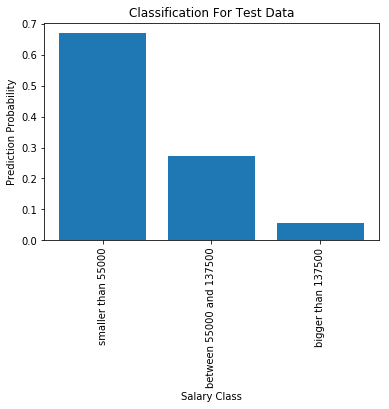

In [759]:
salaryClasses=['smaller than 55000','between 55000 and 137500','bigger than 137500']
probability=[0.67049564,0.94431281-0.67049564,0.05568719 ]

plt.bar(salaryClasses,probability)
plt.title("Classification For Test Data")
plt.xlabel("Salary Class")
plt.ylabel("Prediction Probability")
plt.xticks( rotation=90)
plt.show()

From the output we can see that for label1 the training accuracy was 0.3832523776602811 and testing accuracy was 0.29502129420854173 and the variance of testing data is aroud 0.1 within the acceptance and for label2 the train accuracy is 0.1487570622380922 to 0.02222636613708521 of testing and vairance is also smaller than 0.1, since the model test accuracy is not so smaller than training accuracy and the variance of testing data is within acceptance, I suppose the model is still underfitting. To furthur imporve the accuracy, a couple of methods can be used like, doing a normalization on training data or try increase the size of selected feature dimension.